In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_lima')
backend_config = backend.configuration()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")
backend.configuration().timing_constraints
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
import numpy as np
lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
backend_defaults = backend.defaults()

/tmp/ipykernel_80/1829761861.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Sampling time: 0.2222222222222222 ns
Least common multiple of acquire_alignment and pulse_alignment: 16


In [3]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds
qubit = 0
rough_qubit_frequency = backend_defaults.qubit_freq_est[qubit]
scale_factor = 1e-7

In [4]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [5]:
from qiskit import pulse
from qiskit.circuit import Parameter   
from qiskit.circuit import QuantumCircuit, Gate
drive_amp = 0.05

In [6]:
from qiskit import schedule
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt

In [7]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [8]:
drive_amp = Parameter('drive_amp')
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [9]:
drive_sigma_sec = 0.015 * us                           
drive_duration_sec = drive_sigma_sec * 8
pi_amp = 0.09330023645106622
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

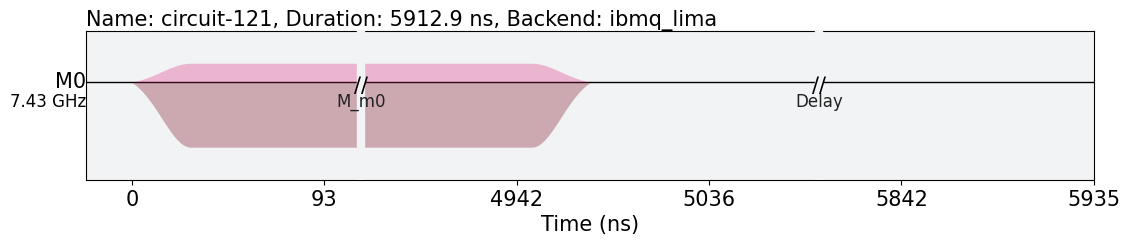

In [10]:
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

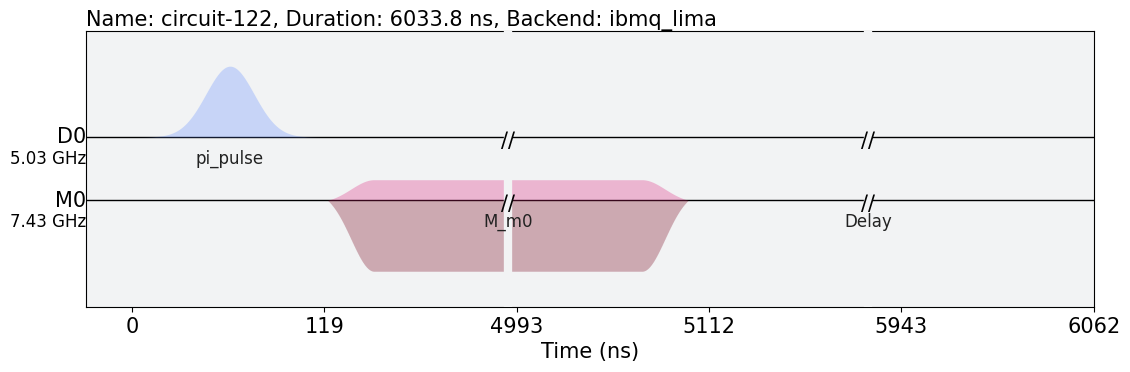

In [11]:
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)
    qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [20]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, -2.3-3.3j) < distance(point, 2.2-3.1j))

In [21]:
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [22]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)
qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

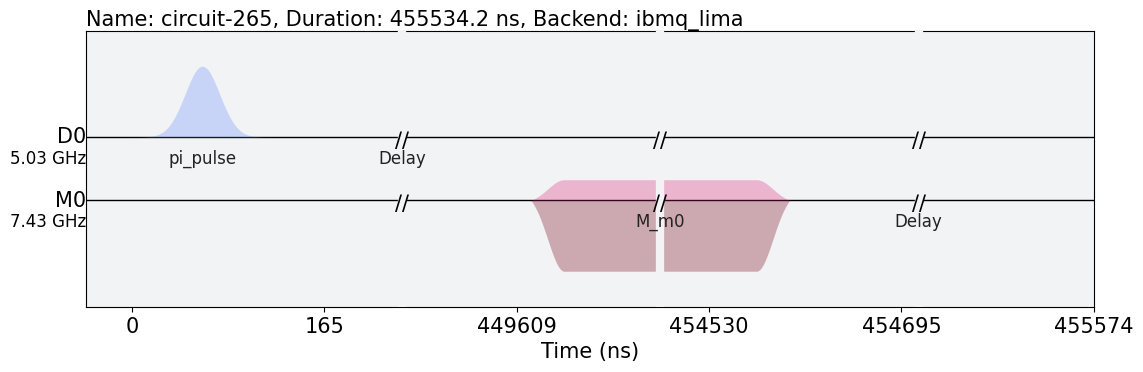

In [23]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [24]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [25]:
t1_results = job.result()

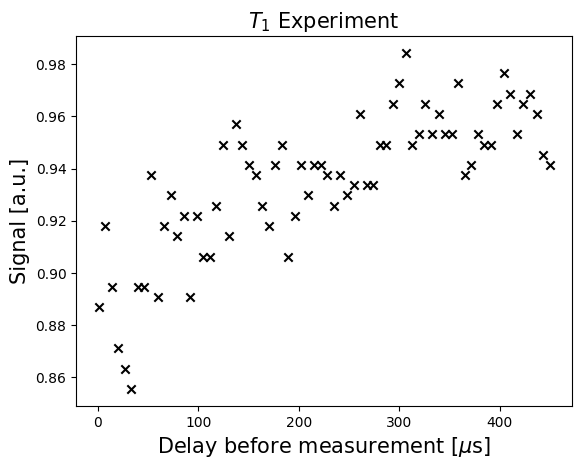

In [26]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

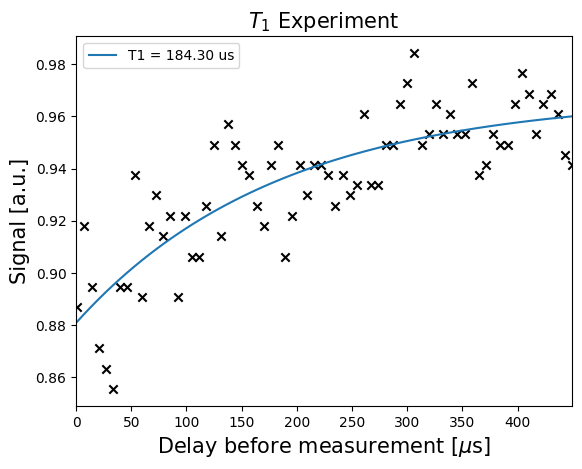

In [27]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

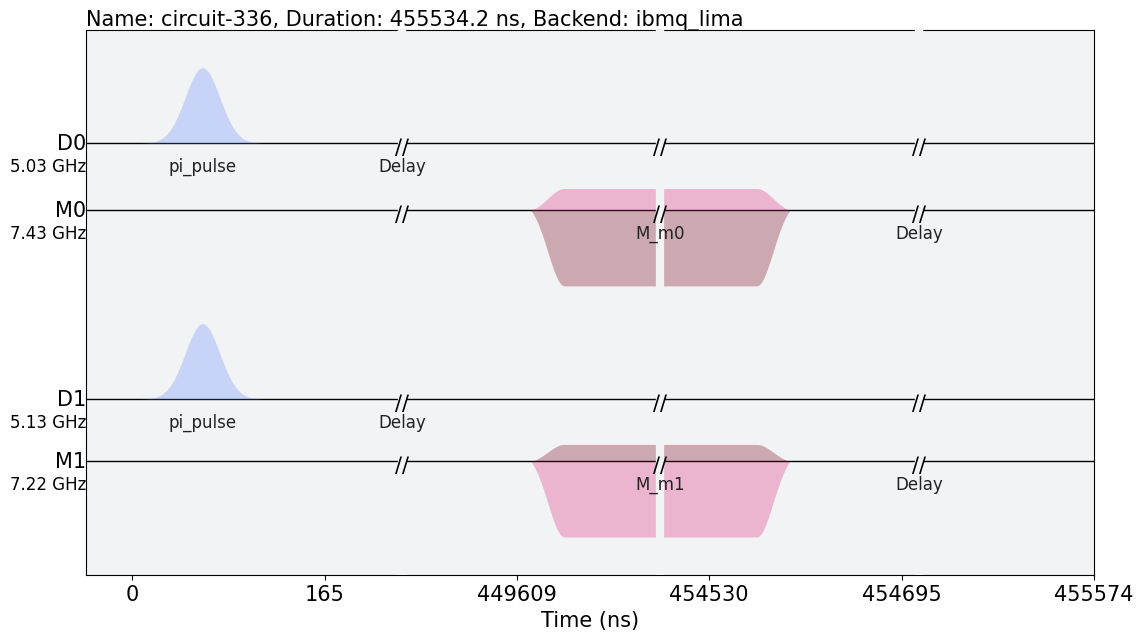

In [28]:
with pulse.build(backend) as pi_pulse1:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(1)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

delay = Parameter('delay')
qc_t1 = QuantumCircuit(2, 2)
qc_t1.x(0)
qc_t1.x(1)
qc_t1.delay(delay, 0)
qc_t1.delay(delay, 1)
qc_t1.measure(0, 0)
qc_t1.measure(1,1)
qc_t1.add_calibration("x", (0,), pi_pulse)
qc_t1.add_calibration("x", (1,), pi_pulse1)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [29]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


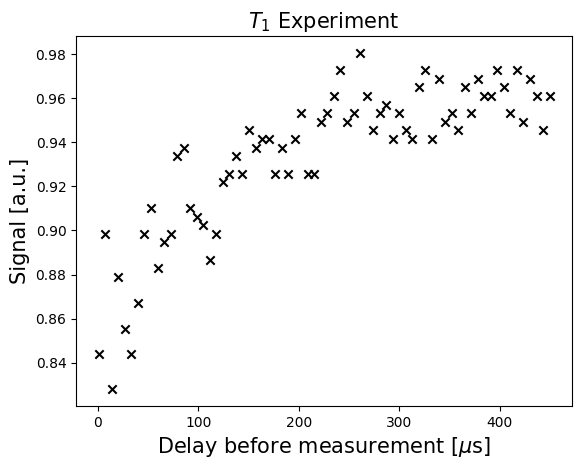

In [30]:
t1_results = job.result()
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

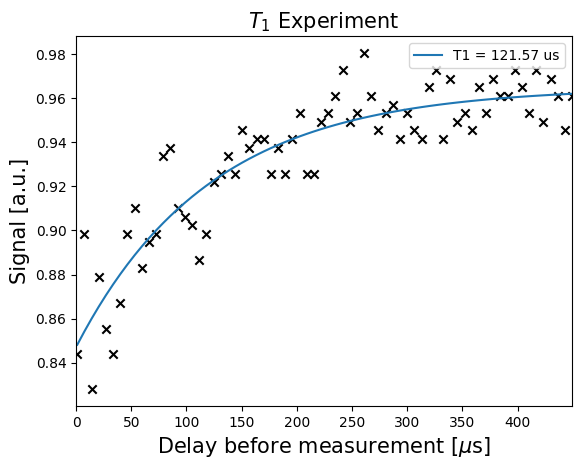

In [31]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

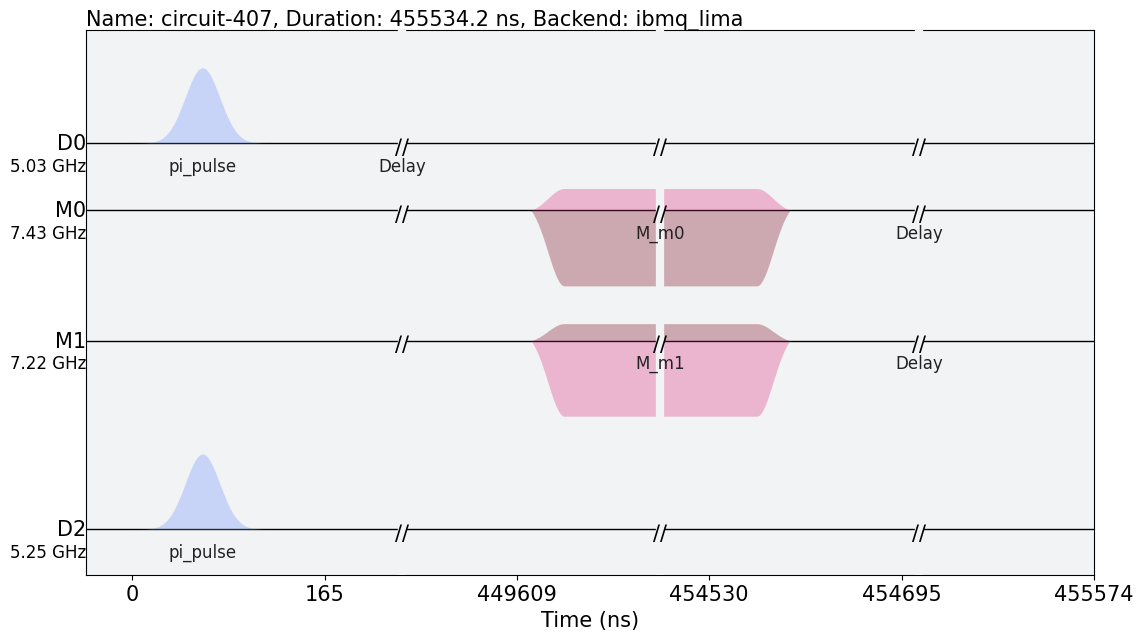

In [32]:
with pulse.build(backend) as pi_pulse2:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(2)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

delay = Parameter('delay')
qc_t1 = QuantumCircuit(2, 2)
qc_t1.x(0)
qc_t1.x(1)
qc_t1.delay(delay, 0)
qc_t1.delay(delay, 1)
qc_t1.measure(0, 0)
qc_t1.measure(1,1)
qc_t1.add_calibration("x", (0,), pi_pulse)
qc_t1.add_calibration("x", (1,), pi_pulse2)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [33]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


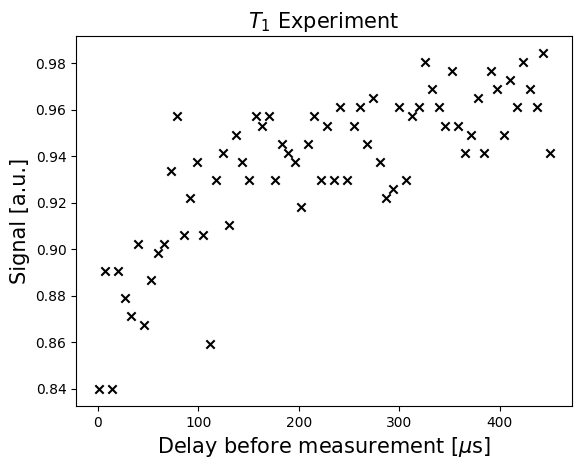

In [34]:
t1_results = job.result()
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

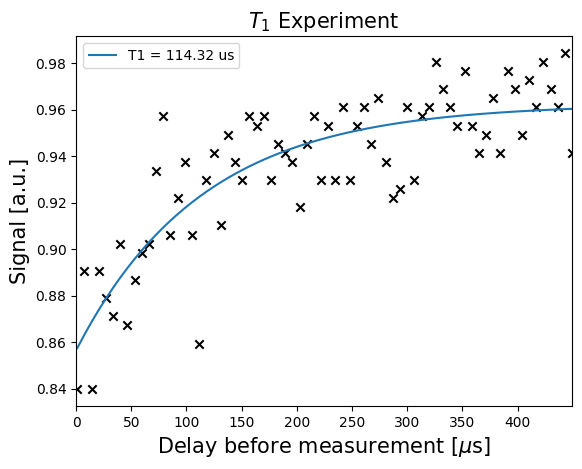

In [35]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

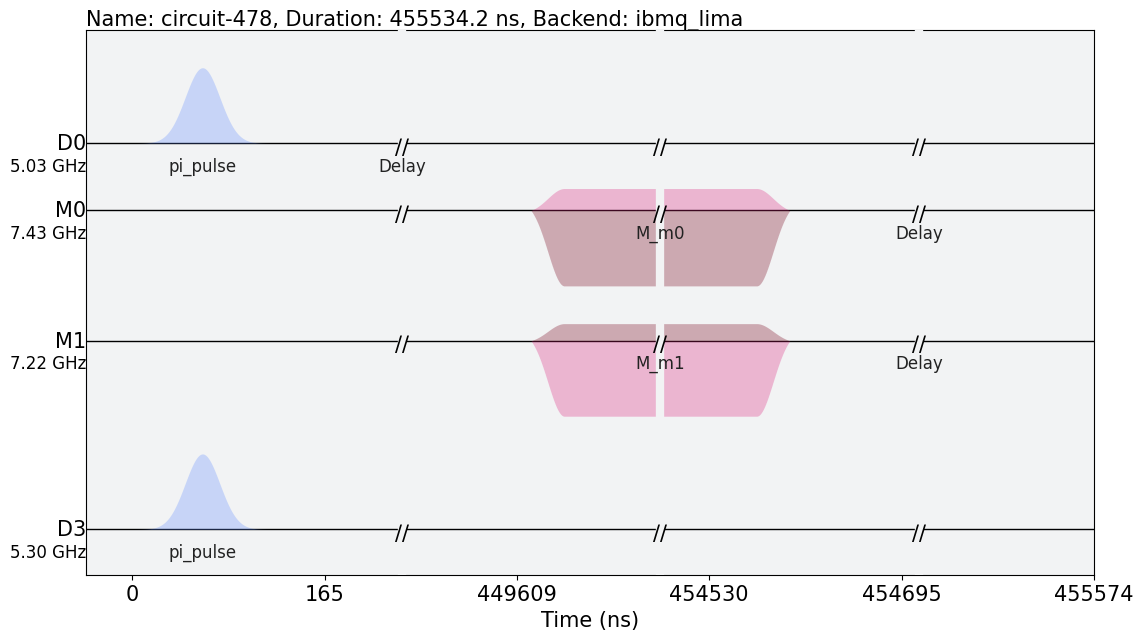

In [36]:
with pulse.build(backend) as pi_pulse3:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(3)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

delay = Parameter('delay')
qc_t1 = QuantumCircuit(2, 2)
qc_t1.x(0)
qc_t1.x(1)
qc_t1.delay(delay, 0)
qc_t1.delay(delay, 1)
qc_t1.measure(0, 0)
qc_t1.measure(1,1)
qc_t1.add_calibration("x", (0,), pi_pulse)
qc_t1.add_calibration("x", (1,), pi_pulse3)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [37]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


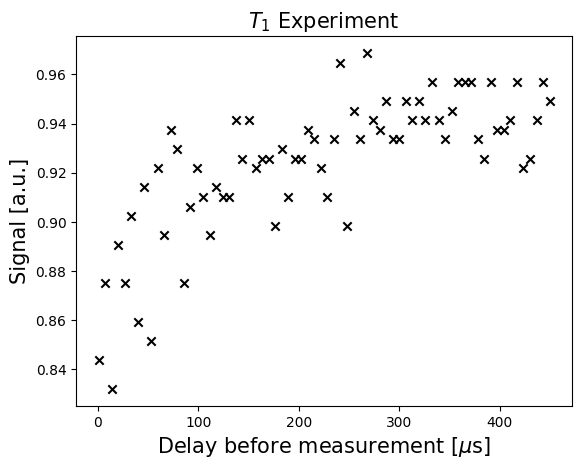

In [38]:
t1_results = job.result()
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

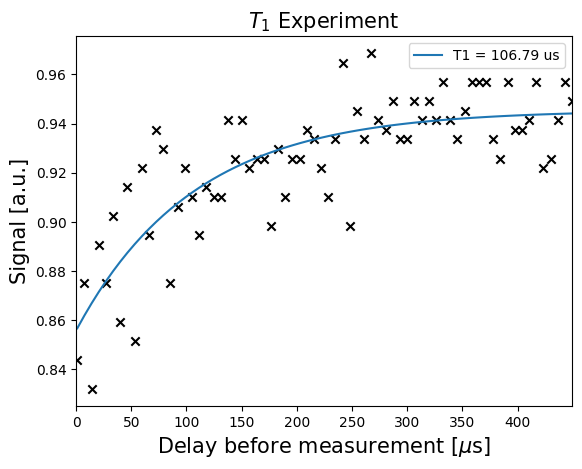

In [39]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

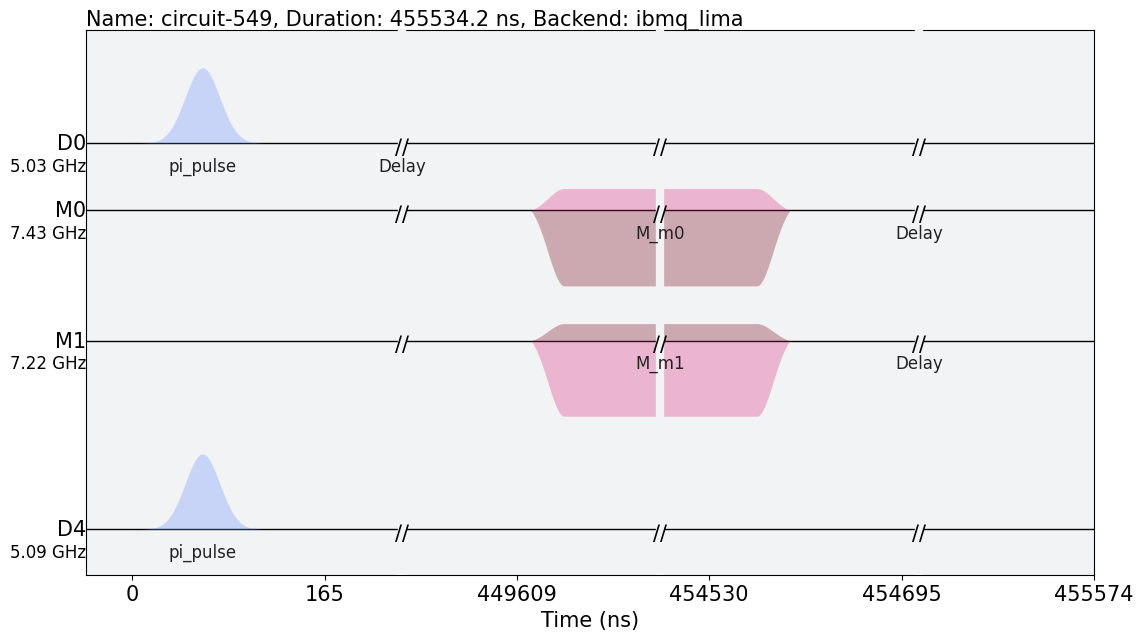

In [40]:
with pulse.build(backend) as pi_pulse4:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(4)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

delay = Parameter('delay')
qc_t1 = QuantumCircuit(2, 2)
qc_t1.x(0)
qc_t1.x(1)
qc_t1.delay(delay, 0)
qc_t1.delay(delay, 1)
qc_t1.measure(0, 0)
qc_t1.measure(1,1)
qc_t1.add_calibration("x", (0,), pi_pulse)
qc_t1.add_calibration("x", (1,), pi_pulse4)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [41]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


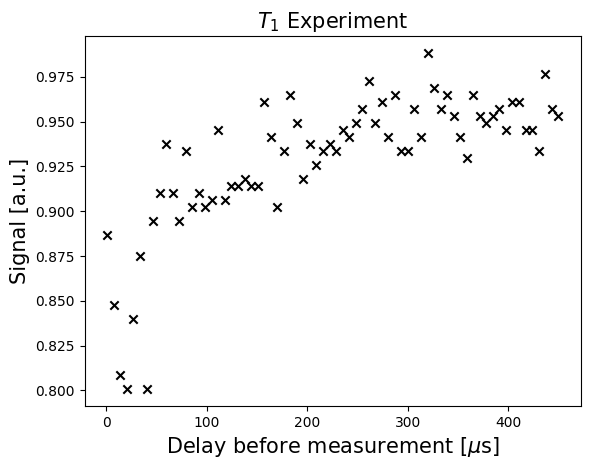

In [42]:
t1_results = job.result()
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

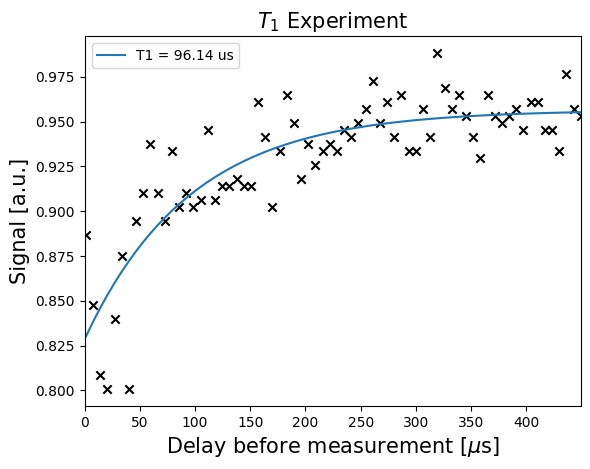

In [43]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

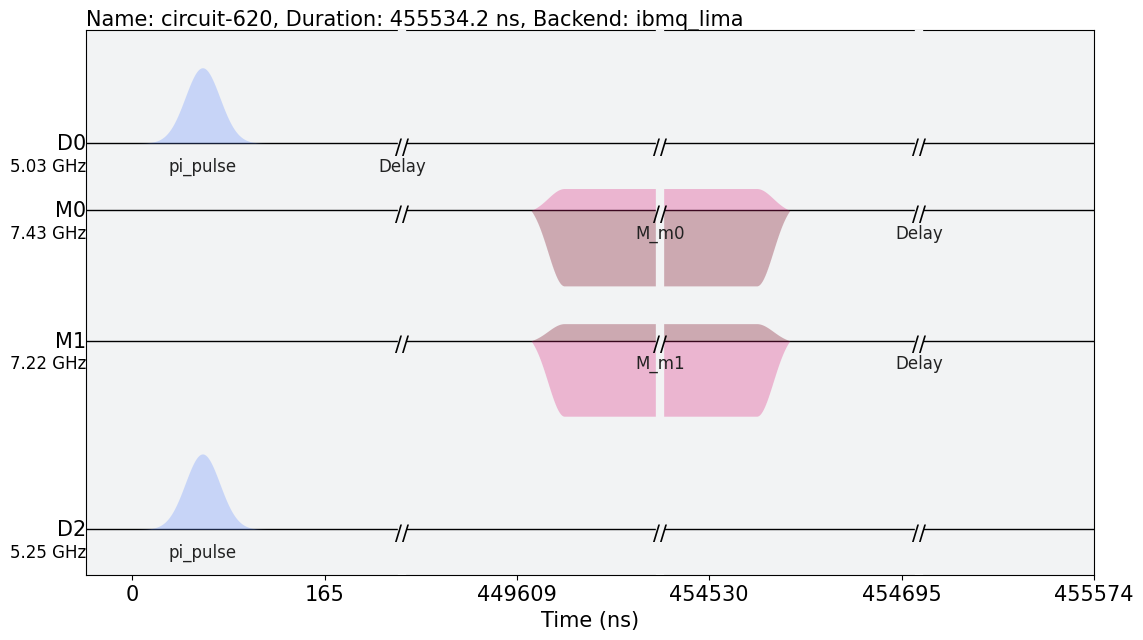

In [44]:
with pulse.build(backend) as pi_pulse2:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(2)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

delay = Parameter('delay')
qc_t1 = QuantumCircuit(2, 2)
qc_t1.x(0)
qc_t1.x(1)
qc_t1.delay(delay, 0)
qc_t1.delay(delay, 1)
qc_t1.measure(0, 0)
qc_t1.measure(1,1)
qc_t1.add_calibration("x", (0,), pi_pulse)
qc_t1.add_calibration("x", (1,), pi_pulse2)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [45]:
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


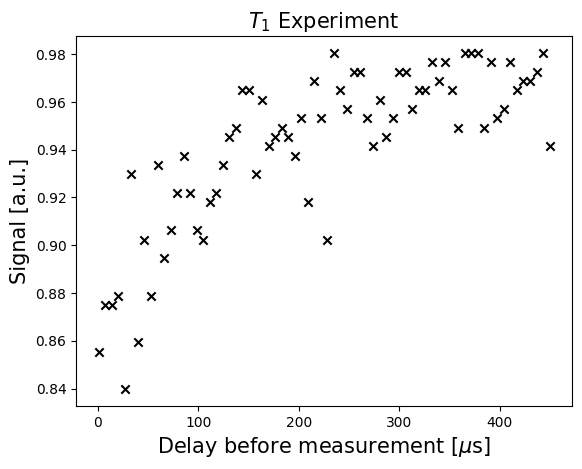

In [46]:
t1_results = job.result()
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

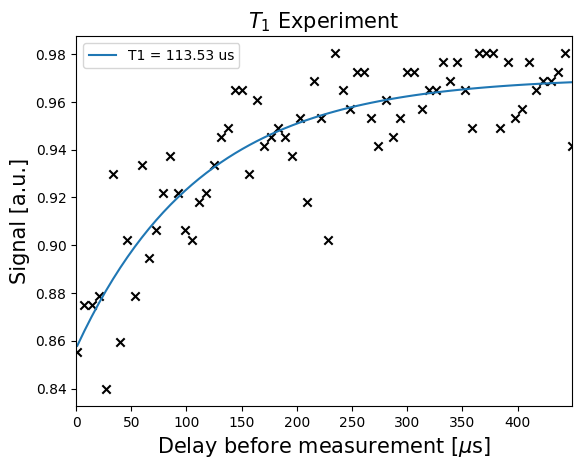

In [47]:
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, marker='x', color='black')
plt.plot(delay_times_sec/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()